#Diabetes Risk Prediction Random Forest Case Study

##Problem Statement

Diabetes is one of the most frequent diseases worldwide and the number of diabetic patients is growing over the years. The main cause of diabetes remains unknown, yet scientists believe that both genetic factors and environmental lifestyle play a major role in diabetes.

Individuals with diabetes face a risk of developing some secondary health issues such as heart diseases and nerve damage. Thus, early detection and treatment of diabetes can prevent complications and assist in reducing the risk of severe health problems. Even though it's incurable, it can be managed by treatment and medication.

Researchers at the Bio-Solutions lab want to get a better understanding of this disease among women and are planning to use machine learning models that will help them to identify patients who are at risk of diabetes.

You as a data scientist at Bio-Solutions have to build a classification model using a dataset collected by the "National Institute of Diabetes and Digestive and Kidney Diseases" consisting of several attributes that would help to identify whether a person is at risk of diabetes or not.

##Objective

To build a model to predict whether an individual is at risk of diabetes or not and identify the most important factors for this prediction.

## Data Dictionary

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration over 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skinfold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* Pedigree: Diabetes pedigree function - A function that scores likelihood of diabetes based on family history.
* Age: Age in years
* Class: Class variable (0: the person is not diabetic or 1: the person is diabetic)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#Tuning and metric modules
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df = pd.read_csv('/content/pima-indians-diabetes.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   Pedigree       768 non-null    float64
 7   Age            768 non-null    int64  
 8   Class          768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* No missing values
* All data types are appropriate.
* Class, the only categorical variable, has already been encoded.

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


* BMI, Insulin, SkinThickness, BloodPressure, and Glucose have minimum values of 0 which might be an error.
* There is more than 2 standard deviations of difference between the 3rd quartile and maximum value for Pregnancies, SkinThickness, Insulin, BMI, and Age which suggests there might be outliers.

In [6]:
print(f'This data set has {df.shape[0]} rows and {df.shape[1]} cols.')

This data set has 768 rows and 9 cols.


## EDA

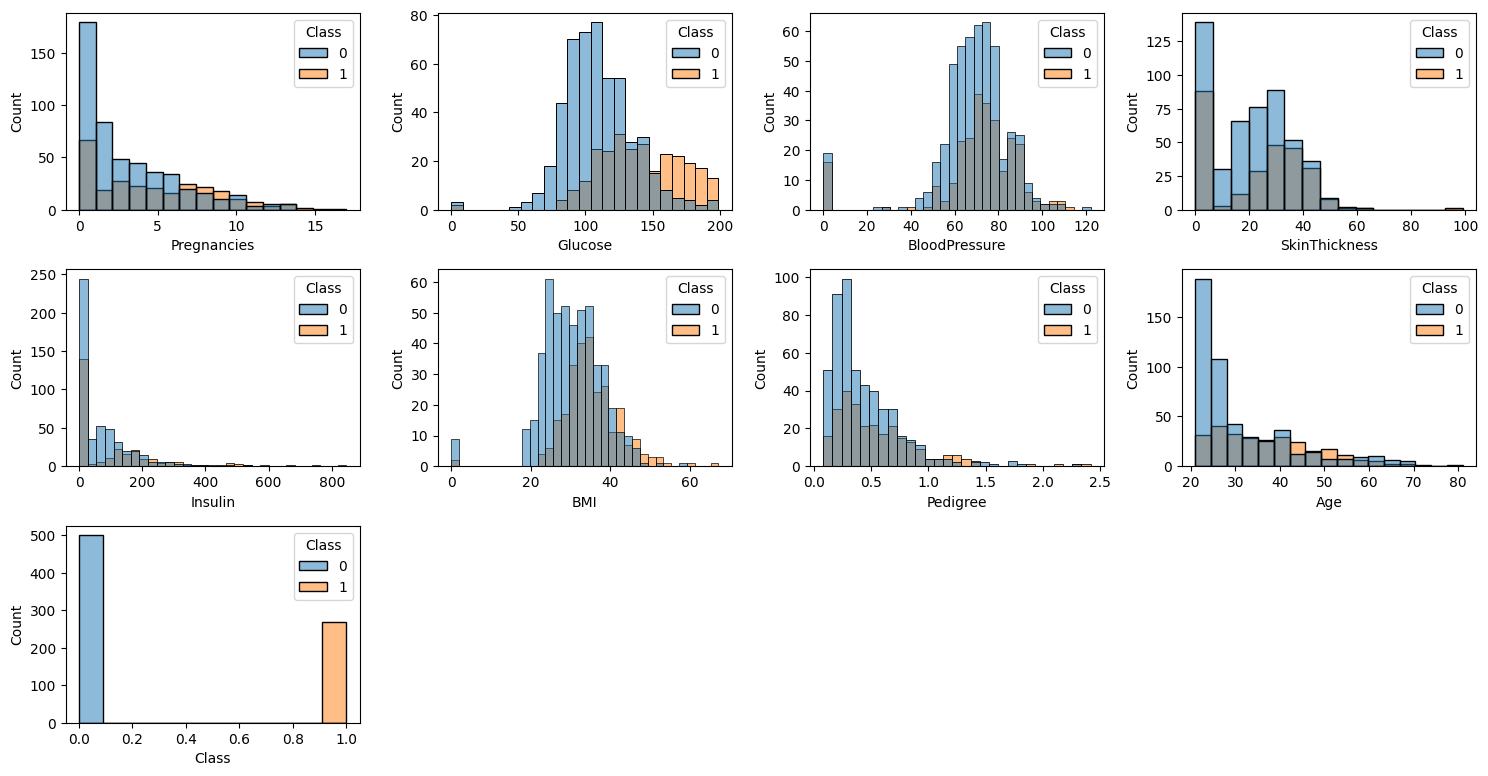

In [7]:
plt.figure(figsize=(15,10))

for i, feature in enumerate(df):
  plt.subplot(4, 4, i+1)
  sns.histplot(data=df, x=feature, hue='Class')

plt.tight_layout();

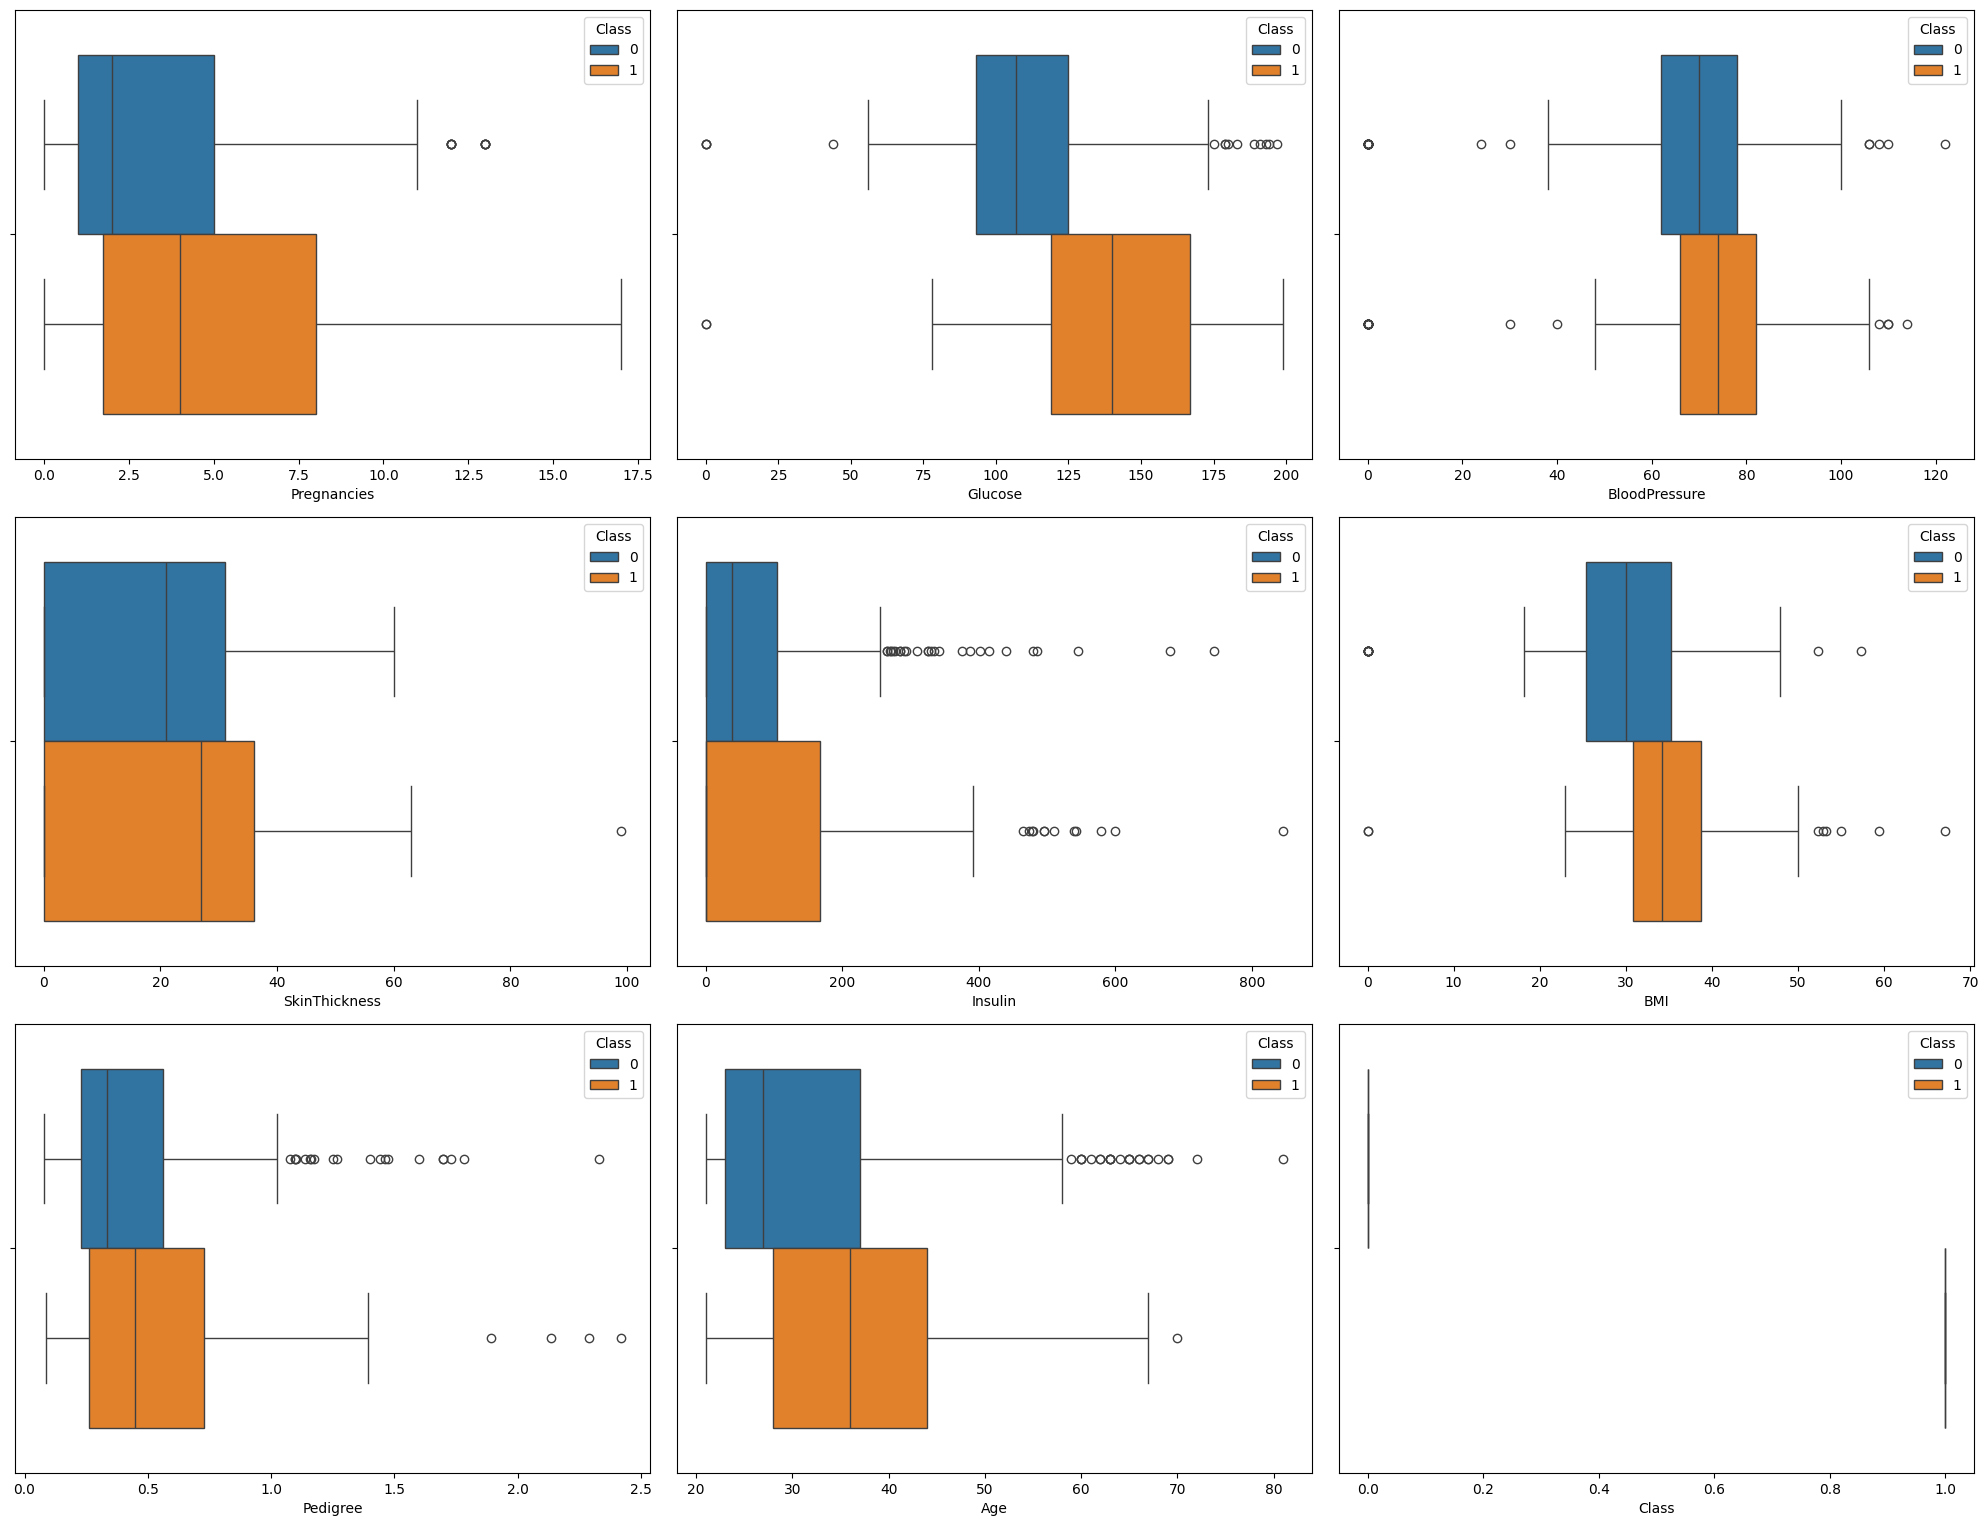

In [8]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(df):
  plt.subplot(4,3, i+1)
  sns.boxplot(data=df, x=feature, hue='Class')

plt.tight_layout();

<Axes: >

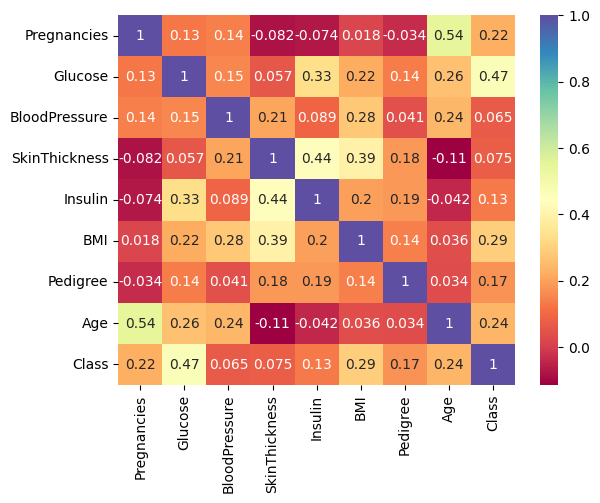

In [9]:
sns.heatmap(data=df.corr(), annot=True, cmap='Spectral')

### EDA Summary

* Participants that have diabetes also, usually have more pregnancies.
* Participants that have diabetes also tend to have higher glucose.
* Participants that have diabetes also have a higher median blood pressure.
* Participants that have diabetes tend to have a slightly higher SkinThickness.
* Participants that have diabetes tend to have slightly elevated insulin.
* Participants that have diabetes usually have a higher median BMI.
* Participants that are older seem to have a higher risk of diabetes.

* Glucose, Pregnancies, Insulin, BMI, and age all have a moderate to high correlation with diabetes.


# Model Building

### Model Evaluation

#### The most impactful prediction the model can get wrong:

* Predicting a person doesn't have diabetes, but they do.

####Metric Optimization

The model predicting that a person is not at risk of diabetes when they are is the most impactful prediction the model can get wrong because that person will not undergo additional testing and may go completely undiagnosed. On the other hand, if the model predicts that a person is at risk of diabetes, but they actually are not they will undergo additional testing to confirm the prediction. So, in order to minimize the most impactful case I will maximize recall, as a higher recall score translates to lower false negatives.

### Data Pre-Processing

In [10]:
x = df.drop('Class', axis=1)
y = df['Class']

In [11]:
#Stratify ensures that the original distribution of the target feature is split between the train and test sets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)
print(x_train.shape, x_test.shape)

(537, 8) (231, 8)


In [12]:
def model_performance(model, predictors, target):
  '''
  Function to compute model performance metrics.

  model - classifier
  predictors - x variables
  target - y variables
  '''

  #Use the x features to make a prediction using the model.
  pred = model.predict(predictors)

  acc = accuracy_score(target, pred)
  recall = recall_score(target, pred)
  percision = precision_score(target, pred)
  f1 = f1_score(target, pred)

  #dataframe of metrics
  df_pref = pd.DataFrame(
      {
          "Accuracy": acc,
          "Recall": recall,
          "Precision": percision,
          "F1": f1,
      },
      index = [0]
  )

  return df_pref

In [13]:
def confusion_matrix_model(model, predictors, target):
  '''
  Function to plot confusion matrix.

  model - classifier
  predictors - x variables
  target - y variables
  '''

  pred = model.predict(predictors)
  cm = confusion_matrix(target, pred)
  labels = np.asarray(
      [
         ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
         for item in cm.flatten()
      ]
  ).reshape(2,2)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=labels, fmt="")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")



### Default Decision Tree

In [14]:
#Fit the model to the default decision tree.
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(x_train, y_train)

#Calc the different metrics for the train and test sets
dtree_model_train_perf = model_performance(d_tree, x_train, y_train)
print('Training performance:\n', dtree_model_train_perf)
dtree_model_test_perf = model_performance(d_tree, x_test, y_test)
print('Testing performance:\n', dtree_model_test_perf)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0   0.74026  0.592593       0.64  0.615385


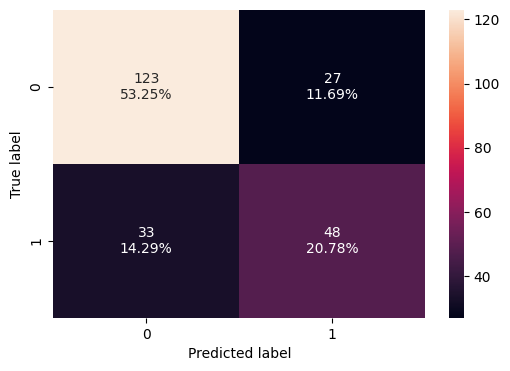

In [15]:
#Confusion matrix for the default decision tree.
confusion_matrix_model(d_tree, x_test, y_test)

The decision tree has perfect performance across the board for the training data, but under performs on the testing data. The tree overfit and is having a hard time generalizing to new data.

### Default Random Forest

In [16]:
#Fit the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(x_train, y_train)

#Calculating perfomance metrics
rf_estimator_model_train_perf = model_performance(rf_estimator, x_train, y_train)
print('Traininig performance: \n', rf_estimator_model_train_perf)
rf_estimator_model_test_perf = model_performance(rf_estimator, x_test, y_test)
print('Testing performance: \n', rf_estimator_model_test_perf)

Traininig performance: 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance: 
    Accuracy    Recall  Precision        F1
0  0.731602  0.518519   0.646154  0.575342


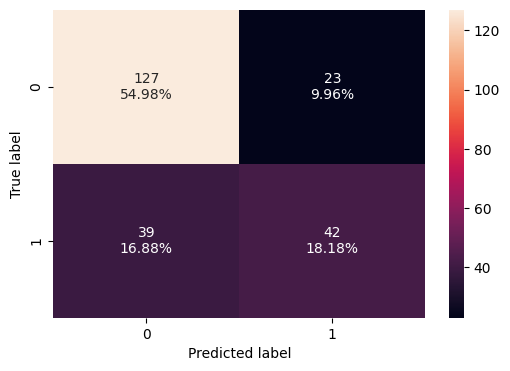

In [17]:
#Confusion matrix
confusion_matrix_model(rf_estimator, x_test, y_test)

Just like the decision tree, the random forest is overfitting on the data. This is evident in the performance gap between the train and test set.

### Default Bagging Classifier

In [18]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(x_train, y_train)

#Calc performance metrics
bagging_classifier_model_train_perf = model_performance(bagging_classifier, x_train, y_train)
print('Training performance:\n', bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf = model_performance(bagging_classifier, x_test, y_test)
print('Testing performance:\n', bagging_classifier_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.994413  0.983957        1.0  0.991914
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.744589  0.567901   0.657143  0.609272


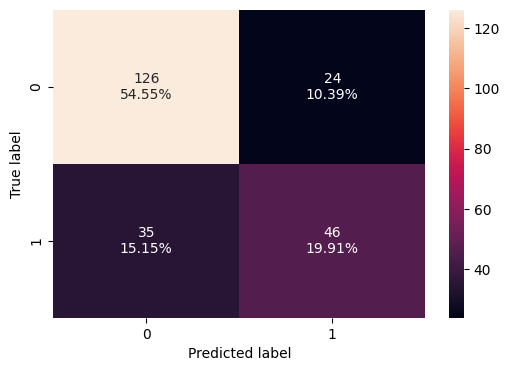

In [19]:
#Confusion matrix
confusion_matrix_model(bagging_classifier, x_test, y_test)

* The default bagging classifier has a similar performance to the default random forest. It is also overfitting the training data.

### Tuned Decision Tree

In [20]:
#Init the decision tree classifier.
#Setting the class_weights to 0.35 for class zero and 0.65 for class one to deal with
  #imbalanced class.
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.35,1:0.65}, random_state=1)

#Params Grid
parameters = {
    'max_depth': np.arange(2,10),
    'min_samples_leaf': [5,7,10,15],
    'max_leaf_nodes': [2,3,5,10,15],
    'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
}

#Set the recall as the metric to compare the models when tuning.
scorer = metrics.make_scorer(metrics.recall_score)

#Fit the grid search.
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer, n_jobs=-1)
grid_obj = grid_obj.fit(x_train, y_train)

#Set the model to the best combination of parameters.
dtree_estimator = grid_obj.best_estimator_

#Fit the best model to the data.
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=4,
                       max_leaf_nodes=5, min_impurity_decrease=0.0001,
                       min_samples_leaf=5, random_state=1)

In [21]:
#Calculating performance metrics
dtree_estimator_model_train_perf=model_performance(dtree_estimator,x_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance(dtree_estimator,x_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.756052  0.828877   0.610236  0.702948
Testing performance:
    Accuracy    Recall  Precision        F1
0   0.69697  0.753086    0.54955  0.635417


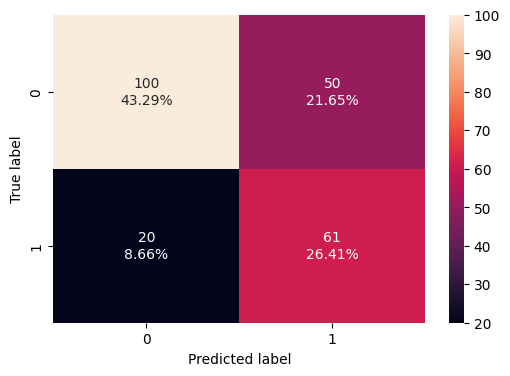

In [22]:
#Confusion matrix
confusion_matrix_model(dtree_estimator, x_test, y_test)

* The tuned decision tree has a much better recall and percision score than the default model

### Tuned Random Forest

In [23]:
#Init the rt model and set the class weights
rf_tuned = RandomForestClassifier(class_weight={0:0.35, 1: 0.65}, random_state=1)

#Params grid
parameters = {
    'max_depth': np.arange(3,10,1),
    'max_features': np.arange(0.6,1.1,0.1),
    'max_samples': np.arange(0.7,1.1,0.1),
    'min_samples_split': np.arange(2,20, 5),
    'n_estimators': np.arange(30,160,20),
    'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
}

#Scoring the models based on recall to compare parameter combinations.
scorer = metrics.make_scorer(metrics.recall_score)

#Run the grid search
grid_obj = RandomizedSearchCV(rf_tuned, parameters, scoring=scorer, n_jobs=-1, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

#Set the model to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

#Fit the optimized model
rf_tuned.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 0.35, 1: 0.65}, max_depth=5,
                       max_features=0.9999999999999999,
                       max_samples=0.7999999999999999,
                       min_impurity_decrease=0.0001, min_samples_split=12,
                       n_estimators=70, random_state=1)

In [24]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance(rf_tuned,x_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance(rf_tuned,x_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.869646  0.877005   0.777251  0.824121
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.718615  0.617284   0.595238  0.606061


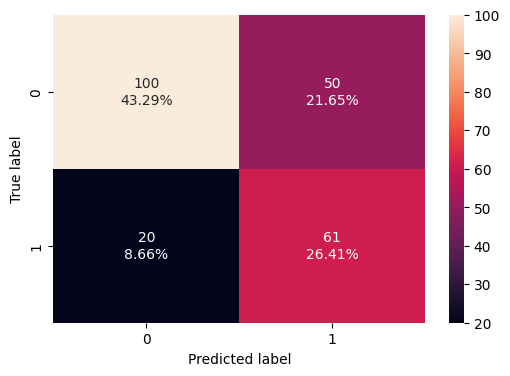

In [25]:
#Confusion matrix
confusion_matrix_model(dtree_estimator, x_test, y_test)

* This tuned model drastically imrpoved the recall score compared to the default, but the model is still overfitting the training data.

###Tuned Bagging Classifier

In [26]:
#Init the classifer
bg_tuned =  BaggingClassifier(random_state=1)

#Params grid
parameters = {
    'max_samples': [0.7,0.8,0.9,1], #Number of rows to sample.
    'max_features': [0.5,0.6,0.7,0.8,0.9,1], #Percentage of features to use during each sample.
    'n_estimators': [10,20,30,40,50] #Number of estimator models to use.
}

#Score the models based on recall.
scorer = metrics.make_scorer(metrics.recall_score)

#Run the grid search
grid_obj = RandomizedSearchCV(bg_tuned, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_test, y_test)

#Set the model to the best combination of parameters
bg_tuned = grid_obj.best_estimator_

#Fit the optimized model
bg_tuned.fit(x_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.7, n_estimators=20,
                  random_state=1)

In [27]:
#Calculating different metrics
bg_tuned_model_train_perf=model_performance(bg_tuned,x_train,y_train)
print("Training performance:\n",bg_tuned_model_train_perf)
bg_tuned_model_test_perf=model_performance(bg_tuned,x_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.979516  0.941176        1.0  0.969697
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.718615  0.617284   0.595238  0.606061


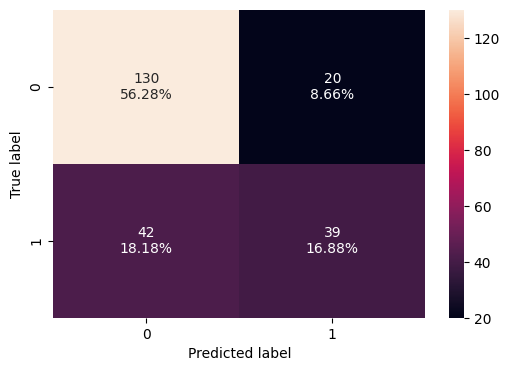

In [28]:
#Confusion matrix
confusion_matrix_model(bg_tuned, x_test, y_test)

* The recall score for the testing data decreased after model tuning.

### Comparing all the models

In [29]:
#Training performance comparison
models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bg_tuned_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Default Decision Tree",
    "Tuned Decision Tree",
    "Default Random Forest ",
    "Tuned Random Forest",
    "Defualt Bagging Classifier",
    "Tuned Bagging Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Default Decision Tree,Tuned Decision Tree,Default Random Forest,Tuned Random Forest,Defualt Bagging Classifier,Tuned Bagging Classifier
Accuracy,1.0,0.756052,1.0,0.869646,0.994413,0.979516
Recall,1.0,0.828877,1.0,0.877005,0.983957,0.941176
Precision,1.0,0.610236,1.0,0.777251,1.000000,1.000000
F1,1.0,0.702948,1.0,0.824121,0.991914,0.969697


In [30]:
models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T, bg_tuned_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Default Decision Tree",
    "Tuned Decision Tree",
    "Default Random Forest ",
    "Tuned Random Forest",
    "Defualt Bagging Classifier",
    "Tuned Bagging Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Default Decision Tree,Tuned Decision Tree,Default Random Forest,Tuned Random Forest,Defualt Bagging Classifier,Tuned Bagging Classifier
Accuracy,0.740260,0.696970,0.731602,0.718615,0.744589,0.731602
Recall,0.592593,0.753086,0.518519,0.617284,0.567901,0.481481
Precision,0.640000,0.549550,0.646154,0.595238,0.657143,0.661017
F1,0.615385,0.635417,0.575342,0.606061,0.609272,0.557143


The tuned decision tree has the highest recall score, and it gives a generalized performance compared to the other models.

#Feature Importance of The Tuned Decision Tree

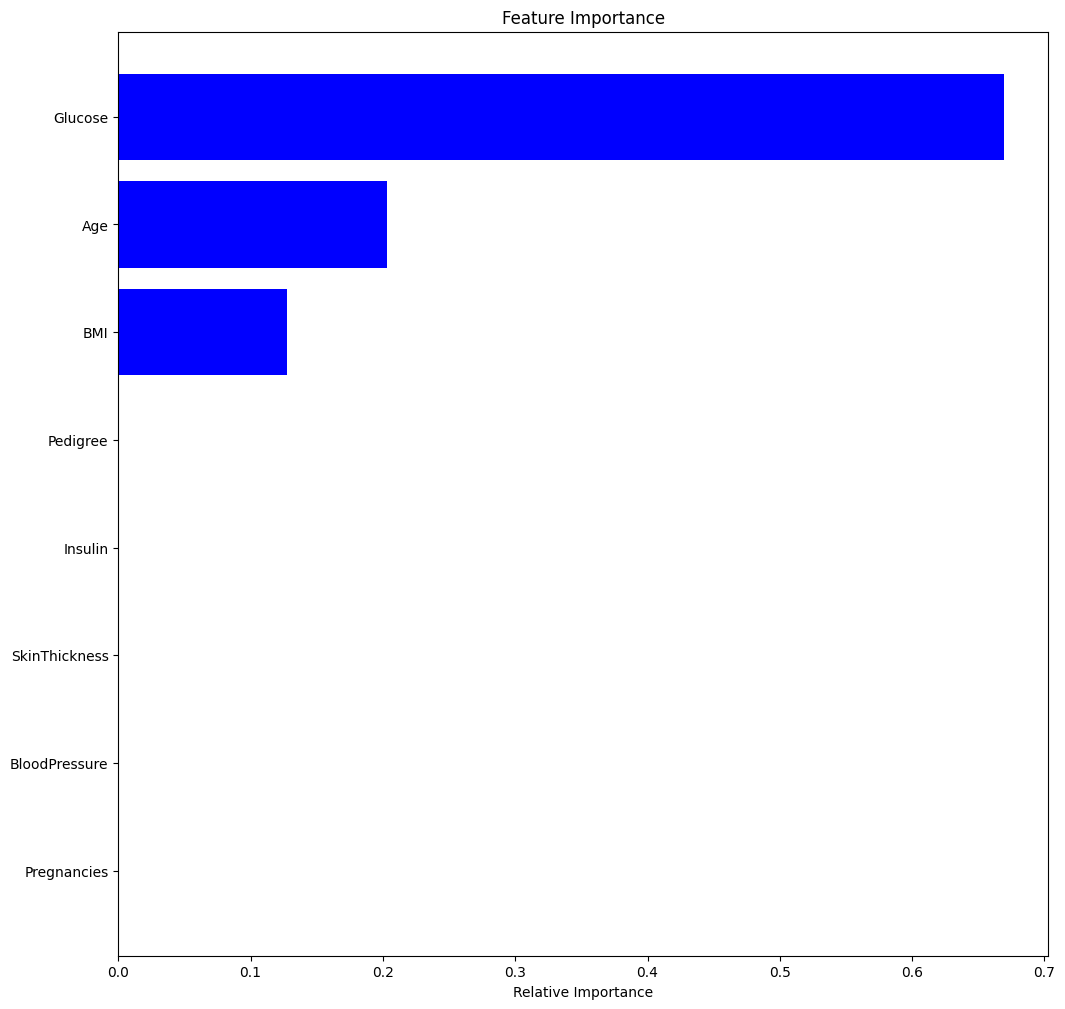

In [33]:
feature_names = x_train.columns
importances = dtree_estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()